In [1]:
import numpy as np
from scipy.sparse import save_npz, csc_matrix, load_npz
from scipy.stats import sem
from scipy.signal import medfilt
from utils import *
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(font_scale=2, style='ticks')

In [2]:
# define synaptic input using synaptic condutance g, gating variable s, postsynaptic Vm
def synInput(g, s, Es, V):
    if np.isscalar(g):
        return -g*s*(V-Es) # this is usually the case for independent noisy input
    else:
        return -np.matmul(g, s)*(V-Es) # this is for general connections

# define gating dynamics
def gateDynamicsS(s, tau_s, is_pre_spike, tau):
    return s + tau*(-s/tau_s + is_pre_spike)

# AMPA dynamics # glutamate
def ampaInput(g, s, V, is_pre_spike, tau):
    s = gateDynamicsS(s, 2.0, is_pre_spike, tau)
    return synInput(g, s, 0.0, V), s

In [3]:
def AdLIFire(Cm, EL, gL, Vth, Vr, tau_u, a, b, tau, V, u, I):
    V = V + tau/Cm*(-gL*(V-EL) + I - u)
    u = u + tau/tau_u *(a*(V-EL) - u)
    VV = V.copy()
    # spike events resets
    VV[V>=Vth] = Vth + 5
    u[V>=Vth] = u[V>=Vth] + b
    is_spike  = np.zeros(V.shape)
    is_spike[V>=Vth] = 1.0
    V[V>=Vth]  = Vr
    return V, VV, u, is_spike

def neuronAfterFire(V, VV, is_spike, last_spike_time, Vr, tau_ref, tau):
    V[last_spike_time > -tau_ref] = Vr
    # VV[last_spike_time > -tau_ref] = Vr
    last_spike_time[last_spike_time > -tau_ref] = last_spike_time[last_spike_time > -tau_ref] - tau
    last_spike_time[is_spike==1.0] = 0.0
    return V, VV, last_spike_time

In [4]:
def excAdLIF(tau, V, u, last_spike_time, I):
    Cm = 0.5 # nF
    gL = 0.025 # uS
    EL = -60.0
    Vth = -40.0
    Vr = -50.0
    tau_ref = 2.0 # ms
    tau_u = 200.0 # ms
    a = 0.025 # 0.03 # subvoltage adaptation #0.025
    b = 0.015 # spike adaptation
    V, VV, u, is_spike = AdLIFire(Cm, EL, gL, Vth, Vr, tau_u, a, b, tau, V, u, I)
    V, VV, last_spike_time = neuronAfterFire(V, VV, is_spike, last_spike_time, Vr, tau_ref, tau)
    return V, VV, u, last_spike_time, is_spike

In [5]:
num_tot = 1000
t_end = 5500.0
t_init = 3000.0
tau = 0.1 # ms
tspan = np.arange(0.0, t_end, step=tau)
t_gaba = 500.00
t_glut = 700.00
VV_list = []
Vsub_list = []

noise_vec = 5 * np.ones(num_tot) #kHz
g_noise = 0.0000240 * 1000.0
V_tot = -50 + 6*np.random.rand(num_tot)
u = 0.45 * np.ones(V_tot.shape)
initial_constant = 0.8
ampa_s_noise = np.random.rand(num_tot) * initial_constant
last_spike_time_tot = np.ones(num_tot) * -3.0
is_pre_spike_tot = np.zeros(num_tot)

InputSig = np.zeros(int(t_end/tau))
Igaba = np.r_[-np.ones(int(t_gaba/tau))*0.05, np.zeros(int((1000.0-t_gaba)/tau))] #0.01
# Igaba = -np.exp(-np.arange(1000.0/tau)/3500.0)*0.15 #0.20
t_glut_on = 500.0
Iglut = np.ones(int(t_glut/tau))*0.01
InputSig[int(t_init/tau):int((t_init+1000)/tau)] += Igaba
InputSig[int((t_init+t_glut_on)/tau):int((t_init+t_glut_on+t_glut)/tau)] += Iglut

VV = []
Vsub = []
for t, I0 in zip(tspan, InputSig):
    # pre noise
    is_noise_pre_spike = np.random.rand(num_tot) > np.exp(-tau*noise_vec)
    I_noise, ampa_s_noise = ampaInput(g_noise, ampa_s_noise, V_tot, is_noise_pre_spike, tau)
    I = I_noise + I0
    V_tot, V_, u, last_spike_time_tot, is_pre_spike_tot = excAdLIF(tau, V_tot, u, last_spike_time_tot, I)
    VV.append(is_pre_spike_tot)
    Vsub.append(V_)

VV_list.append(np.array(VV))
Vsub_list.append(np.array(Vsub))


## swim only
noise_vec = 5 * np.ones(num_tot) #kHz
g_noise = 0.0000240 * 1000.0
V_tot = -50 + 6*np.random.rand(num_tot)
u = 0.45 * np.ones(V_tot.shape)
initial_constant = 1.1
ampa_s_noise = np.random.rand(num_tot) * initial_constant
last_spike_time_tot = np.ones(num_tot) * -3.0
is_pre_spike_tot = np.zeros(num_tot)

InputSig = np.zeros(int(t_end/tau))
InputSig[int(t_init/tau):int((t_init+1000)/tau)] += Igaba


VV = []
Vsub = []
for t, I0 in zip(tspan, InputSig):
    # pre noise
    is_noise_pre_spike = np.random.rand(num_tot) > np.exp(-tau*noise_vec)
    I_noise, ampa_s_noise = ampaInput(g_noise, ampa_s_noise, V_tot, is_noise_pre_spike, tau)
    I = I_noise + I0
    V_tot, V_, u, last_spike_time_tot, is_pre_spike_tot = excAdLIF(tau, V_tot, u, last_spike_time_tot, I)
    VV.append(is_pre_spike_tot)
    Vsub.append(V_)

VV_list.append(np.array(VV))
Vsub_list.append(np.array(Vsub))

## visual only
noise_vec = 5 * np.ones(num_tot) #kHz
g_noise = 0.0000240 * 1000.0
V_tot = -50 + 6*np.random.rand(num_tot)
u = 0.45 * np.ones(V_tot.shape)
initial_constant = 1.1
ampa_s_noise = np.random.rand(num_tot) * initial_constant
last_spike_time_tot = np.ones(num_tot) * -3.0
is_pre_spike_tot = np.zeros(num_tot)

InputSig = np.zeros(int(t_end/tau))
InputSig[int((t_init+t_glut_on)/tau):int((t_init+t_glut_on+t_glut)/tau)] += Iglut

VV = []
Vsub = []
for t, I0 in zip(tspan, InputSig):
    # pre noise
    is_noise_pre_spike = np.random.rand(num_tot) > np.exp(-tau*noise_vec)
    I_noise, ampa_s_noise = ampaInput(g_noise, ampa_s_noise, V_tot, is_noise_pre_spike, tau)
    I = I_noise + I0
    V_tot, V_, u, last_spike_time_tot, is_pre_spike_tot = excAdLIF(tau, V_tot, u, last_spike_time_tot, I)
    VV.append(is_pre_spike_tot)
    Vsub.append(V_)
    
VV_list.append(np.array(VV))
Vsub_list.append(np.array(Vsub))


## visual - delayed
noise_vec = 5 * np.ones(num_tot) #kHz
g_noise = 0.0000240 * 1000.0
V_tot = -50 + 6*np.random.rand(num_tot)
u = 0.45 * np.ones(V_tot.shape)
initial_constant = 1.1
ampa_s_noise = np.random.rand(num_tot) * initial_constant
last_spike_time_tot = np.ones(num_tot) * -3.0
is_pre_spike_tot = np.zeros(num_tot)

t_glut_on = 800.0
Iglut = np.ones(int(t_glut/tau))*0.01
InputSig = np.zeros(int(t_end/tau))
InputSig[int(t_init/tau):int((t_init+1000)/tau)] += Igaba
InputSig[int((t_init+t_glut_on)/tau):int((t_init+t_glut_on+t_glut)/tau)] += Iglut


VV = []
Vsub = []
for t, I0 in zip(tspan, InputSig):
    # pre noise
    is_noise_pre_spike = np.random.rand(num_tot) > np.exp(-tau*noise_vec)
    I_noise, ampa_s_noise = ampaInput(g_noise, ampa_s_noise, V_tot, is_noise_pre_spike, tau)
    I = I_noise + I0
    V_tot, V_, u, last_spike_time_tot, is_pre_spike_tot = excAdLIF(tau, V_tot, u, last_spike_time_tot, I)
    VV.append(is_pre_spike_tot)
    Vsub.append(V_)
    
VV_list.append(np.array(VV))
Vsub_list.append(np.array(Vsub))

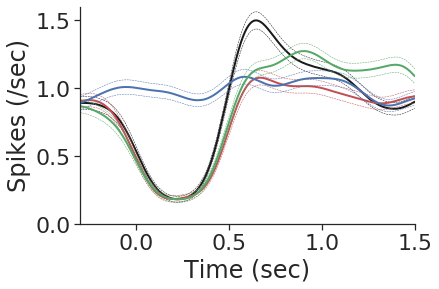

In [9]:
c_list = ['k', 'r', 'b', 'g']
labels = ['CL', 'Swim-only', 'Visual-only']
# t_pre = t_init
t_pre = 1000.0
f_ = 1/tau*1000
t_start = int((t_init-t_pre)/tau)
# t_start = 0
t_label = np.arange(-t_pre, t_end-t_init, tau)/1000.0

for n, nVV in enumerate(VV_list):
    # plt_raster(nVV[t_start:].T, t_shift=10000, f_=f_)
    #plt.show()

    k_ = gaussKernel(sigma=1001)
    spk_list = nVV[t_start:].T
    tmp = []
    for n_trial in range(spk_list.shape[0]):
        tmp.append(smooth(spk_list[n_trial], k_))
    spk_list = np.array(tmp)
    mean_ = np.mean(spk_list, axis=0)*f_
    std_ = sem(spk_list, axis=0, nan_policy='omit')*f_
    plt.plot(t_label, mean_, f'-{c_list[n]}', lw=2)
    plt.plot(t_label, mean_-std_, f'--{c_list[n]}', lw=0.5)
    plt.plot(t_label, mean_+std_, f'--{c_list[n]}', lw=0.5)
    
plt.xlim([-0.3, 1.5])
plt.ylim([0, 1.6])
plt.xlabel('Time (sec)')
plt.ylabel('Spikes (/sec)')
sns.despine()
plt.savefig('../Plots/model/example_neuron.svg')

In [7]:
# c_list = ['k', 'r', 'b', 'g']
# labels = ['CL', 'Swim-only', 'Visual-only']
# k_sub = 100

# for n, nVV in enumerate(Vsub_list):
#     t_pre = 1000.0
#     f_ = 1/tau*1000
#     t_start = int((t_init-t_pre)/tau)
#     k_ = boxcarKernel(sigma=101)
#     spk_list = nVV[t_start:].T
#     spk_list[spk_list>-40] = -60
#     tmp = []
#     for n_trial in range(spk_list.shape[0]):
#         # _ = medfilt(spk_list[n_trial], kernel_size=k_sub*2+1)
#         tmp.append(smooth(spk_list[n_trial], k_))
#         # tmp.append(_)
#     spk_list = np.array(tmp)
#     t_label = np.arange(-t_pre, 1500.0, tau)/1000.0
#     mean_ = np.mean(spk_list, axis=0)# np.percentile(spk_list, 20, axis=0)
#     std_ = sem(spk_list, axis=0, nan_policy='omit')
#     plt.plot(t_label[100:-100], mean_[100:-100], f'-{c_list[n]}', lw=2)
#     plt.plot(t_label[100:-100], mean_[100:-100]-std_[100:-100], f'--{c_list[n]}', lw=0.5)
#     plt.plot(t_label[100:-100], mean_[100:-100]+std_[100:-100], f'--{c_list[n]}', lw=0.5)

# # plt.ylim([-45, -43])
# # plt.xlim([-0.5, 1])
# plt.xlabel('Time (sec)')
# plt.ylabel('Voltage (mV)')
# sns.despine()
# plt.show()